# 1. Introduction
This notebook performs heart disease classification using the K-Nearest Neighbors (KNN) algorithm.
We load and clean data from multiple sources, preprocess features, and evaluate the model performance.

# 2. Load and combine data

In [1]:
import pandas as pd

col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]

file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.va.data',       False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),
]

frames = []
for path, space_sep in file_info:
    df = pd.read_csv(
        path,
        sep=r'\s+' if space_sep else ',',
        header=None,
        names=col_names,
        na_values='?'
    )
    frames.append(df)
data = pd.concat(frames, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed.cleveland.data'

# 3. Feature Overview


1. age – Age of the person
2. sex – Sex (1 = male, 0 = female)
3. cp – Chest pain type (0–3, categorical)
4. stbps – Resting blood pressure
5. l – Serum cholesterol
6. fbs – Fasting blood sugar > 120 mg/dl (1 = yes, 0 = no)
7. restecg – Resting electrocardiographic results (0–2)
8. thalach – Maximum heart rate achieved
9. exang – Exercise-induced angina (1 = yes, 0 = no)
10. oldpeak – ST depression induced by exercise
11. slope – Slope of the peak exercise ST segment (0–2)
12. ca – Number of major vessels colored by fluoroscopy (0–3)
13. thal – Thalassemia (0–3, encoded)
14. target – Target variable (0 = no heart disease, 1 = heart disease)

# 4. Preprocessing & Modeling Pipeline

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## 4.1 Test Split

In [9]:
X = data.drop('target', axis=1)
y = data['target'].astype(int).apply(lambda v: 1 if v>0 else 0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 4.2  Preprocessing and Pipeline Setup

In [10]:
numeric_cols     = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])


## 4.3 Hyperparameter-Tuning

In [11]:
param_grid = {'knn__n_neighbors': list(range(1,21))}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best k:", grid.best_params_['knn__n_neighbors'])

Best k: 19


# 5. Final Evaluation

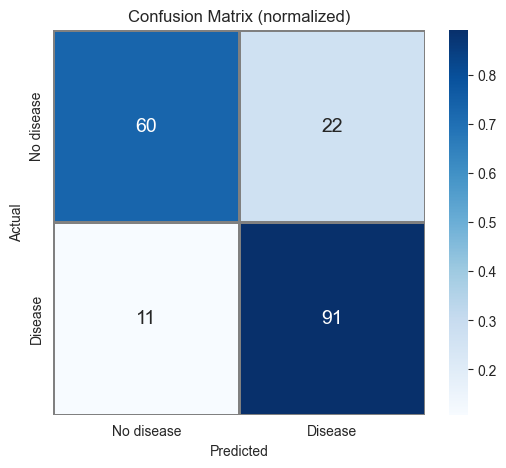

,precision,recall,f1-score,support
0,0.85,0.73,0.78,82.00
1,0.81,0.89,0.85,102.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.83,0.81,0.82,184.00
weighted avg,0.82,0.82,0.82,184.00


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# 1) Prediction
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# 2) Normalisation
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

# 3) Plot with Seaborn
labels = ['No disease', 'Disease']
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=cm,                # absolute Zahlen zusätzlich
    fmt='d',                 # Anzeige-Format für die Zahlen
    annot_kws={'size':14},   # Schriftgröße
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (normalized)')
plt.show()

# 4) Classification Report as DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T
display(df_report.style.format({
    'precision': '{:.2f}',
    'recall':    '{:.2f}',
    'f1-score':  '{:.2f}',
    'support':   '{:.2f}'
}))